In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
#import datetime as dt
from datetime import datetime
 

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Create a Base
#reflect an existing database into a new model
Base = automap_base()
# reflect the tables 
Base.prepare(autoload_with=engine)  

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement 
Station = Base.classes.station

In [8]:
# Check the columns in the table Measurement 
from sqlalchemy import inspect
inspector = inspect(engine)
cols=inspector.get_columns('measurement')
for c in cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Check the columns in the table Station
cols=inspector.get_columns('station')
for c in cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(recent_date)
rd=datetime.strptime(recent_date,"%Y-%m-%d")

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.     

# Calculate the date one year from the last date in data set.
last_year=datetime(year=rd.year-1, month=rd.month, day=rd.day).date() 
print(last_year)


2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores 
precip_12_months=session.query(Measurement.date,func.max(Measurement.prcp)).filter(Measurement.date.between('2016-08-23' , '2017-08-23')). \
                     group_by(func.substr(Measurement.date,9,2)).order_by(Measurement.date).all()
print(precip_12_months)

[('2016-08-23', 1.79), ('2016-08-24', 2.28), ('2016-08-31', 2.46), ('2016-09-06', 1.0), ('2016-09-10', 1.16), ('2016-09-14', 6.7), ('2016-09-15', 3.35), ('2016-10-04', 3.46), ('2016-10-20', 1.0), ('2016-10-27', 1.25), ('2016-11-16', 0.91), ('2016-11-21', 2.87), ('2016-12-03', 1.62), ('2016-12-05', 1.6), ('2016-12-26', 1.48), ('2016-12-30', 2.37), ('2017-01-25', 2.64), ('2017-02-07', 1.8), ('2017-02-11', 5.04), ('2017-02-12', 2.98), ('2017-02-13', 2.9), ('2017-03-01', 2.4), ('2017-03-02', 1.88), ('2017-04-17', 1.3), ('2017-04-28', 2.6), ('2017-04-29', 6.25), ('2017-05-08', 1.11), ('2017-05-09', 1.62), ('2017-06-19', 0.4), ('2017-07-18', 2.4), ('2017-07-22', 4.0)]


In [27]:
#Create a dictionary with the results and save it for its use in Flask
precip_12_dict = dict((x, y) for x, y in precip_12_months)
print(precip_12_dict)

{'2016-08-23': 1.79, '2016-08-24': 2.28, '2016-08-31': 2.46, '2016-09-06': 1.0, '2016-09-10': 1.16, '2016-09-14': 6.7, '2016-09-15': 3.35, '2016-10-04': 3.46, '2016-10-20': 1.0, '2016-10-27': 1.25, '2016-11-16': 0.91, '2016-11-21': 2.87, '2016-12-03': 1.62, '2016-12-05': 1.6, '2016-12-26': 1.48, '2016-12-30': 2.37, '2017-01-25': 2.64, '2017-02-07': 1.8, '2017-02-11': 5.04, '2017-02-12': 2.98, '2017-02-13': 2.9, '2017-03-01': 2.4, '2017-03-02': 1.88, '2017-04-17': 1.3, '2017-04-28': 2.6, '2017-04-29': 6.25, '2017-05-08': 1.11, '2017-05-09': 1.62, '2017-06-19': 0.4, '2017-07-18': 2.4, '2017-07-22': 4.0}


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(precip_12_months,columns=['Date','Precipitation'])

df=df.set_index('Date', inplace=False)
precipitation_df=df.sort_index()
precipitation_df.head(5)

,Precipitation
Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-31,2.46
2016-09-06,1.00
2016-09-10,1.16


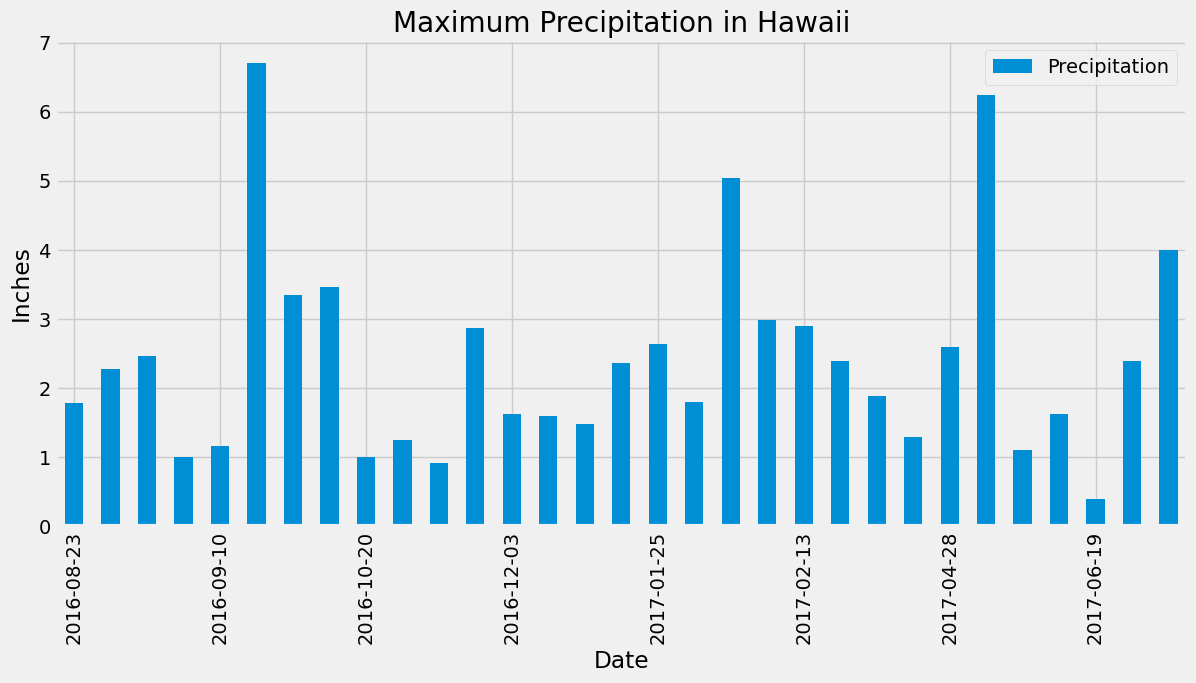

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

precipitation_df.plot.bar( y='Precipitation',figsize=(13,6))
plt.title('Maximum Precipitation in Hawaii')
plt.xlabel('Date')
ax = plt.gca()                  # This functions were shared with me by one of my class peers
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))  #This functions were shared with me by one of my peers

plt.ylabel("Inches")
# Save the figure
plt.savefig("output/Max_prcp.png")

plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df.describe())

       Precipitation
count      31.000000
mean        2.407097
std         1.476149
min         0.400000
25%         1.390000
50%         2.280000
75%         2.885000
max         6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
total_stations=session.query(func.count(Station.station)).all()[0]
print(F"The database has {total_stations[0]} stations")

The database has 9 stations


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_list=session.query(Measurement.station,func.count(Measurement.prcp)).filter(Measurement.prcp > 0). \
                    group_by(Measurement.station). order_by(func.count(Measurement.prcp).desc()).all()
print(most_active_list)

[('USC00519281', 1973), ('USC00516128', 1937), ('USC00513117', 1765), ('USC00519523', 1191), ('USC00514830', 1114), ('USC00519397', 919), ('USC00511918', 534), ('USC00518838', 256), ('USC00517948', 229)]


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=(most_active_list[0])[0]    #USC00519281
lowest_temp=session.query(Measurement.station,func.min(Measurement.tobs)). \
                    filter(Measurement.station == most_active_station).all()
highest_temp=session.query(Measurement.station,func.max(Measurement.tobs)). \
                    filter(Measurement.station == most_active_station).all()
average_temp=session.query(Measurement.station,func.avg(Measurement.tobs)). \
                    filter(Measurement.station == most_active_station).all()
print(f"Station {most_active_station} registered temperatures of {lowest_temp[0][1]} (min), {highest_temp[0][1]} (max) and {average_temp[0][1]} (average)")

Station USC00519281 registered temperatures of 54.0 (min), 85.0 (max) and 71.66378066378067 (average)


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12=session.query(Measurement.date,Measurement.tobs). \
                    filter(Measurement.date.between('2016-08-23' , '2017-08-23'), \
                           Measurement.station ==most_active_station). \
                           order_by(Measurement.date).all() #group_by(func.substr(Measurement.date,9,2))
print(most_active_12)


[('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10

In [22]:
#Save the query results as a Pandas DataFrame
df1=pd.DataFrame(most_active_12,columns=['Date','Temperature'])

df1=df1.set_index('Date', inplace=False)
precipitation_most_active=df1.sort_index()
len(precipitation_most_active)

352

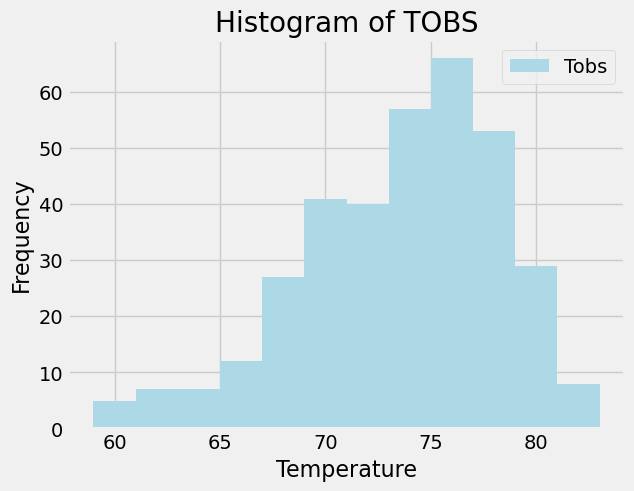

In [23]:
# Plot the result using an histogram 
#This code 
plt.hist(x=precipitation_most_active['Temperature'], bins=12, color='lightblue', histtype='bar') 
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.legend(['Tobs'])
plt.title('Histogram of TOBS',fontsize=20)
# Save the figure
plt.savefig("output/Most_active.png")

plt.show();

In [24]:
#Create a dictionary with the results
most_active_dict = dict((x, y) for x, y in most_active_12)
print(most_active_dict)


{'2016-08-23': 77.0, '2016-08-24': 77.0, '2016-08-25': 80.0, '2016-08-26': 80.0, '2016-08-27': 75.0, '2016-08-28': 73.0, '2016-08-29': 78.0, '2016-08-30': 77.0, '2016-08-31': 78.0, '2016-09-01': 80.0, '2016-09-02': 80.0, '2016-09-03': 78.0, '2016-09-04': 78.0, '2016-09-05': 78.0, '2016-09-06': 73.0, '2016-09-07': 74.0, '2016-09-08': 80.0, '2016-09-09': 79.0, '2016-09-10': 77.0, '2016-09-11': 80.0, '2016-09-12': 76.0, '2016-09-13': 79.0, '2016-09-14': 75.0, '2016-09-15': 79.0, '2016-09-16': 78.0, '2016-09-17': 79.0, '2016-09-18': 78.0, '2016-09-19': 78.0, '2016-09-20': 76.0, '2016-09-21': 74.0, '2016-09-22': 77.0, '2016-09-23': 78.0, '2016-09-24': 79.0, '2016-09-25': 79.0, '2016-09-26': 77.0, '2016-09-27': 80.0, '2016-09-28': 78.0, '2016-09-29': 78.0, '2016-09-30': 78.0, '2016-10-01': 77.0, '2016-10-02': 79.0, '2016-10-03': 79.0, '2016-10-04': 79.0, '2016-10-05': 79.0, '2016-10-06': 75.0, '2016-10-07': 76.0, '2016-10-08': 73.0, '2016-10-09': 72.0, '2016-10-10': 71.0, '2016-10-11': 77.0,

In [25]:
#Save dictionaries to a file for its later use in Flask 
import pickle
try:
    precip_12_pk=open('precip_12_pk', 'wb')
    pickle.dump('precip_12_dict', precip_12_pk)
    precip_12_pk.close()

    most_active_pk = open('most_active_pk', 'wb')
    pickle.dump(most_active_dict, most_active_pk)
    most_active_pk.close()
except:
    print('Please check your code')

# Close session

In [12]:
# Close Session
session.close()